In [ ]:
%tensorflow_version 2.x
%load_ext tensorboard

import glob, math, os, re, sys, zipfile
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import pickle as pkl
import matplotlib.pyplot as plt
from functools import reduce
from itertools import cycle
from datetime import datetime
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from IPython.display import display, HTML
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import resample
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

## Authorize Google Drive

In [ ]:
auth.authenticate_user()

## Setup & Install
Basic setup and install additional dependencies

In [ ]:
# Some global variables and general settings
saved_model_dir = './saved_model'
tensorboard_logs = './logs'
pd.options.display.float_format = '{:.2f}'.format
sns.set_context('notebook')
nnet_tools_path = os.path.abspath('NNet')

def print_html(string, tag='span', color=None, size=None):
    size = f'font-size:{size};' if size else ''
    color = f'color:{color};' if color else ''
    display(HTML(f'<{tag} style="{color}{size}">{string}</{tag}>'))

def print_heading(string, color=None):
    print_html(string, tag='h3', color=color)

def print_message(string, color=None):
    print_html(string, color=color)

def download_file_from_gdrive(gdrive_id, output_file):
    # Authenticate google drive
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    # Download csv from GDrive...
    dataset = drive.CreateFile({'id': gdrive_id})
    dataset_filename = dataset['title']
    print_message(f'Downloading {dataset_filename} ({gdrive_id}) from GDrive. Please wait...')
    dataset.GetContentFile(output_file)
    print_message(f'Download {gdrive_id} completed.')

def download_and_unzip(src_url, out_dir='./', zip_file='dl.zip', remove_zip=True):
    print(f'Downloading {src_url} to {zip_file}')
    !wget $src_url -O $zip_file -q --show-progress
    print(f'Download complete. Unzipping {zip_file}')
    z = zipfile.ZipFile(zip_file, 'r')
    z.extractall(out_dir)
    print(f'Unzipped to {out_dir}. Cleaning up...')
    z.close()
    if remove_zip: os.remove(zip_file)

def overwrite_gdrive_file(gdrive_id, input_file):
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    drive_file = drive.CreateFile({'id': gdrive_id})
    drive_file.SetContentFile(input_file)
    drive_file.Upload()
    drive_filename = drive_file['title']
    print(f'Wrote {input_file} to GDrive {drive_filename} ({gdrive_id}).')

def update_path_vars(paths=[]):
    python_path = os.environ.get('PYTHONPATH') or ''
    jupyter_path = os.environ.get('JUPYTER_PATH') or ''
    for path in paths:
        if not path in python_path:
            python_path += f':{path}'
        if not path in jupyter_path:
            jupyter_path += f':{path}'
    os.environ['PYTHONPATH'] = python_path
    os.environ['JUPYTER_PATH'] = jupyter_path

def install_nnet_tools(nnet_tools_path):
    nnet_tools_url = 'https://github.com/sisl/NNet/archive/master.zip'
    download_and_unzip(nnet_tools_url)
    !mv ./NNet-master $nnet_tools_path

def setup_nnet_tools(nnet_tools_path):
    # install nnet tools if not already installed.
    if not os.path.exists(nnet_tools_path):
        install_nnet_tools(nnet_tools_path)
    # add folder to PYTHONPATH & JUPYTER_PATH
    update_path_vars([nnet_tools_path])

# delete sample data
!rm -rf sample_data

# setup nnet tools (for converting model to Stanford's nnet format)
setup_nnet_tools(nnet_tools_path)
# used for conversion to NNet format
from NNet.utils.writeNNet import writeNNet

dl.zip                  [ <=>                ] 359.66K  --.-KB/s    in 0.1s    
Download complete. Unzipping dl.zip
Unzipped to ./. Cleaning up...


## Download Dataset

In [ ]:
# GDrive ID of csv file (AllData_ReactionTime.csv)
# https://drive.google.com/file/d/1WNnAd8lYWMT_mQWwiN6dP2KC6NTLFjXn
gdrive_id='1WNnAd8lYWMT_mQWwiN6dP2KC6NTLFjXn'
dataset_file='all_data_rt.csv'

# GDrive ID of adversarial csv
# https://drive.google.com/file/d/1N9QZm0NXXYPCQnBNrJHPzmWHkU9SSkbg
adv_dataset_gdrive_id='1N9QZm0NXXYPCQnBNrJHPzmWHkU9SSkbg'
adv_dataset_file = 'adv_dataset.csv'

# load the dataset from gdrive if it doesn't exist in the runtime's filesystem.
if not os.path.exists(dataset_file):
    download_file_from_gdrive(gdrive_id, dataset_file)

if not os.path.exists(adv_dataset_file):
    download_file_from_gdrive(adv_dataset_gdrive_id, adv_dataset_file)

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pydrive/files.py", line 134, in __getitem__
    return dict.__getitem__(self, key)
KeyError: 'title'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dis

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pydrive/files.py", line 134, in __getitem__
    return dict.__getitem__(self, key)
KeyError: 'title'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/__init__.py", line 36, in autodetect
    from google.appengine.api import memcache
ModuleNotFoundError: No module named 'google.appengine'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 33, in <module>
    from oauth2client.contrib.locked_file import LockedFile
ModuleNotFoundError: No module named 'oauth2client.contrib.locked_file'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dis

## Import Dataset

In [ ]:
raw_columns = ['ID', 'Name', 'FixationDuration', 'FixationStart', 'FixationSeq', 
               'FixationX', 'FixationY', 'GazeDirectionLeftZ', 'GazeDirectionRightZ', 
               'PupilLeft', 'PupilRight', 'InterpolatedGazeX', 'InterpolatedGazeY', 
               'AutoThrottle', 'AutoWheel', 'CurrentThrottle', 'CurrentWheel', 
               'Distance3D', 'MPH', 'ManualBrake', 'ManualThrottle', 'ManualWheel', 
               'RangeW', 'RightLaneDist', 'RightLaneType', 'LeftLaneDist', 'LeftLaneType', 
               'ReactionTime']
raw_df = pd.read_csv(dataset_file, usecols=raw_columns)
raw_df.set_index(['ID'], inplace=True)

In [ ]:
pure_df = pd.read_csv(dataset_file)
pure_df.set_index(['ID'], inplace=True)

In [ ]:
pure_df

,Unnamed: 0,index,Timestamp,Name,FixationDuration,FixationSeq,FixationStart,FixationX,FixationY,GazeDirectionLeftX,GazeDirectionLeftY,GazeDirectionLeftZ,GazeDirectionRightX,GazeDirectionRightY,GazeDirectionRightZ,PupilLeft,PupilRight,InterpolatedGazeX,InterpolatedGazeY,EventN,EventSource,EventW,Alarm,Mode,AutoThrottle,AutoWheel,CurrentBrake,CurrentThrottle,CurrentWheel,Distance3D,MPH,ManualBrake,ManualGear,ManualThrottle,ManualWheel,PassBy,RangeN,RangeW,RightLaneDist,RightLaneType,LeftLaneDist,LeftLaneType,Speed,ReactionTime
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1190.00,0,0,7102.00,018_M3,1969.00,7.00,3682.00,0.00,0.00,-0.02,0.07,0.86,0.05,0.08,0.83,5.00,5.00,0.00,0.00,0.00,AutoBrakeSample 0.0|AutoThrottleSample 0.0|Cur...,0.00,0.00,1.00,20.00,0.00,0.00,20.00,0.00,683.20,0.00,50.00,1.00,50.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6802.00
1191.00,1,1,7103.00,018_M3,1969.00,7.00,3682.00,0.00,0.00,-0.02,0.07,0.86,0.05,0.08,0.83,5.00,5.00,0.00,0.00,0.00,GSR GSR,0.00,0.00,1.00,20.00,0.00,0.00,20.00,0.00,683.20,0.00,50.00,1.00,50.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6802.00
1192.00,2,2,7118.00,018_M3,1969.00,7.00,3682.00,0.00,0.00,-0.02,0.07,0.86,0.05,0.08,0.83,5.00,5.00,0.00,0.00,0.00,GSR GSR,0.00,0.00,1.00,20.00,0.00,0.00,20.00,0.00,683.20,0.00,50.00,1.00,50.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6802.00
1193.00,3,3,7120.00,018_M3,1969.00,7.00,3682.00,0.00,0.00,-0.02,0.07,0.86,0.05,0.08,0.83,5.00,5.00,0.00,0.00,0.00,ET|GSR GSR,0.00,0.00,1.00,20.00,0.00,0.00,20.00,0.00,683.20,0.00,50.00,1.00,50.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6802.00
1195.00,4,4,7128.00,018_M3,1969.00,7.00,3682.00,0.00,0.00,-0.02,0.07,0.86,0.05,0.08,0.83,5.00,5.00,0.00,0.00,0.00,ET,0.00,0.00,1.00,20.00,0.00,0.00,20.00,0.00,683.20,0.00,50.00,1.00,50.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,6802.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9844281.00,5909106,7549892,1089867.00,004_M1,1232.00,2071.00,1086975.00,0.00,0.00,-0.02,0.07,0.86,0.05,0.08,0.83,5.00,5.00,0.00,0.00,0.00,GSR GSR,0.00,0.00,1.00,15.00,-2.00,0.00,15.00,-2.00,683.20,35.02,0.00,1.00,0.00,-8.00,0.00,0.00,0.00,1.74,3.00,1.76,1.00,15.65,5358.00
9844282.00,5909107,7549893,1089868.00,004_M1,1232.00,2071.00,1086975.00,0.00,0.00,-0.02,0.07,0.86,0.05,0.08,0.83,5.00,5.00,0.00,0.00,0.00,GSR GSR,0.00,0.00,1.00,15.00,-2.00,0.00,15.00,-2.00,683.20,35.02,0.00,1.00,0.00,-8.00,0.00,0.00,0.00,1.74,3.00,1.76,1.00,15.65,5358.00
9844284.00,5909108,7549894,1089870.00,004_M1,1232.00,2071.00,1086975.00,0.00,0.00,-0.02,0.07,0.86,0.05,0.08,0.83,5.00,5.00,0.00,0.00,0.00,ET,0.00,0.00,1.00,15.00,-2.00,0.00,15.00,-2.00,683.20,35.02,0.00,1.00,0.00,-8.00,0.00,0.00,0.00,1.74,3.00,1.76,1.00,15.65,5358.00


In [ ]:
# 5 class using mean & sdev
def create_tot_categories(rt_column):
    rt_mean = round(rt_column.mean())
    rt_sdev = round(rt_column.std())
    bound_1 = rt_mean - rt_sdev
    bound_2 = rt_mean - rt_sdev // 2
    bound_3 = rt_mean + rt_sdev // 2
    bound_4 = rt_mean + rt_sdev
    bins = [float('-inf'), bound_1, bound_2, bound_3, bound_4, float('inf')]
    labels =  np.array(['fast', 'med_fast', 'med', 'med_slow', 'slow'], dtype=object)
    return (bins, labels)

# make a copy the raw data
df = raw_df.copy()

# compute 'TOT' categories
tot_bins, tot_labels = create_tot_categories(df.ReactionTime)
n_categories = len(tot_labels)

df.RightLaneType = df.RightLaneType.astype(int)
df.LeftLaneType = df.LeftLaneType.astype(int)
# convert leftlane type and rightlanetype to categorical:

# add the class to the dataframe
df['TOT'] = pd.cut(df.ReactionTime, bins=tot_bins, labels=tot_labels).astype(object)

# # Select a handful of ppl for saving resource
df['Name'] = df['Name'].str.upper()
chunk_users = [[f'{i}'.zfill(3) + f'_M{j}' for j in range(1, 4)] for i in [13, 14]]
chunk_users = [u for l in chunk_users for u in l]
all_users = df.copy()
df = df.loc[df['Name'].isin(chunk_users)]

In [ ]:
def upsample_minority_TOTs(X_train, y_train, tot_labels, random_state=27):
    # contat the training data together.
    X = pd.concat([X_train, y_train], axis=1)
    # separate majority and minority classes
    buckets = {l: X[X.TOT == l] for l in tot_labels}
    maj_label, majority = reduce(lambda a,b: b if b[1].shape[0] > a[1].shape[0] else a, buckets.items())
    minorities = {k:v for k,v in buckets.items() if k != maj_label}
    # upsample the minority classes
    for k,v in minorities.items():
        buckets[k] = resample(v, replace=True, n_samples=majority.shape[0], random_state=random_state)
    upsampled = pd.concat(buckets.values()).sample(frac=1)
    # split the upsampled data into X and y
    y_train = upsampled['TOT']
    X_train = upsampled.drop('TOT', axis=1)
    return X_train, y_train

def prepare_inputs(X_train, X_test):
    # scales inputs using "standard scaler", and returns 2D numpy array
    scaler = StandardScaler().fit(pd.concat([X_train, X_test]))
    X_train = scaler.transform(X_train.values)
    X_test = scaler.transform(X_test.values)
    return X_train, X_test, scaler

def prepare_target(y_train, y_test, categories):
    # convert target to categorical, and returns 2D numpy array
    y_train = y_train.to_numpy().reshape(-1,1)
    y_test = y_test.to_numpy().reshape(-1,1)
    onehot = OneHotEncoder(categories=categories)
    onehot.fit(np.concatenate([y_train, y_test]))
    y_train = onehot.transform(y_train).toarray()
    y_test = onehot.transform(y_test).toarray()
    return y_train, y_test, onehot

# split features and targets
y = df.TOT
X = df.drop(['Name', 'ReactionTime', 'TOT'], axis=1)

# make results easier to reproduce
random_state = 27

# split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=random_state)

# upsample the training data
X_train, y_train = upsample_minority_TOTs(X_train, y_train, tot_labels)

# scale the inputs
X_train_enc, X_test_enc, scaler = prepare_inputs(X_train, X_test)
# categorize outputs
y_train_enc, y_test_enc, onehot = prepare_target(y_train, y_test, categories=[tot_labels])

print_heading('TOT Value Counts')
print(y_train.value_counts())

med_slow    197738
med         197738
fast        197738
med_fast    197738
slow        197738
Name: TOT, dtype: int64


In [ ]:
# Prepare data used for extended evaluation and verification (all participants)

# split features and targets
Y_verification = all_users.TOT
X_verification = all_users.drop(['Name', 'ReactionTime', 'TOT'], axis=1)
# upsample minority classes
X_verification, Y_verification = upsample_minority_TOTs(X_verification, Y_verification, tot_labels)
# scale the inputs
X_verification = scaler.transform(X_verification.values)
# categorize outputs
Y_verification = onehot.transform(Y_verification.to_numpy().reshape(-1, 1)).toarray()

In [ ]:
def add_adversarial_data(X_train, y_train, adversarial_df):
    y_cols = [f'y{y}' for y in range(y_train.shape[1])]
    y_adv = adv_df[y_cols].values
    X_adv = adv_df.drop(y_cols, axis=1).values
    return np.append(X_train, X_adv, axis=0), np.append(y_train, y_adv, axis=0)

# adv_df = pd.read_csv(adv_dataset_file)
# X_train_enc, y_train_enc = add_adversarial_data(X_train_enc, y_train_enc, adv_df)

In [ ]:
# save the column names & indexes for use during verification
feature_names = list(X.columns)

# display the feature names
print_heading('Feature Names')
print_message(feature_names)

# print the TOT categories
print_heading('TOT Categories')
print('\n'.join(['%s: %9.2f, %7.2f' % (tot_labels[i].rjust(8), tot_bins[i], tot_bins[i+1]) for i in range(n_categories)]))

    fast:      -inf, 1612.00
med_fast:   1612.00, 2802.00
     med:   2802.00, 5180.00
med_slow:   5180.00, 6370.00
    slow:   6370.00,     inf


In [ ]:
def display_processed_data(feature_names, unencoded=True, encoded=True, describe=True):
    if unencoded:
        print_heading('Unencoded Data')
        display(pd.concat([X_train, y_train], axis=1).describe())
        
    if encoded:
        enc_tot_labels = onehot.get_feature_names(input_features=['TOT'])
        print_heading('Encoded Data')
        display(pd.concat([pd.DataFrame(X_train_enc, columns=feature_names),
                           pd.DataFrame(y_train_enc, columns=enc_tot_labels)],
                          axis=1).astype({k:int for k in enc_tot_labels}).describe())

display_processed_data(feature_names, unencoded=False)

,FixationDuration,FixationSeq,FixationStart,FixationX,FixationY,GazeDirectionLeftZ,GazeDirectionRightZ,PupilLeft,PupilRight,InterpolatedGazeX,InterpolatedGazeY,AutoThrottle,AutoWheel,CurrentThrottle,CurrentWheel,Distance3D,MPH,ManualBrake,ManualThrottle,ManualWheel,RangeW,RightLaneDist,RightLaneType,LeftLaneDist,LeftLaneType,TOT_fast,TOT_med_fast,TOT_med,TOT_med_slow,TOT_slow
count,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00,988690.00
mean,0.00,-0.00,-0.00,-0.00,-0.00,-0.00,-0.01,-0.00,0.00,-0.01,-0.01,0.00,0.00,0.00,0.00,-0.01,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.20,0.20,0.20,0.20,0.20
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.01,1.00,1.00,1.00,1.00,0.40,0.40,0.40,0.40,0.40
min,-1.42,-2.52,-2.26,-8.06,-3.51,-2.26,-1.88,-4.00,-3.57,-1.54,-1.25,-1.12,-43.89,-1.75,-95.26,-1.05,-6.06,-0.48,-0.36,-12.34,-0.09,-5.42,-6.53,-5.49,-4.77,0.00,0.00,0.00,0.00,0.00
25%,-0.69,-0.11,-0.07,-0.22,-0.05,0.21,0.21,-0.91,-0.99,-1.54,-1.25,-1.12,-0.20,-0.33,-0.38,-1.05,-0.14,-0.48,-0.36,-0.23,-0.09,-0.41,0.24,-0.37,-0.23,0.00,0.00,0.00,0.00,0.00
50%,0.25,0.10,-0.07,-0.22,-0.05,0.46,0.54,0.36,0.48,0.44,0.05,0.89,-0.04,0.14,-0.08,0.02,0.40,-0.48,-0.36,0.14,-0.09,0.03,0.24,-0.03,-0.23,0.00,0.00,0.00,0.00,0.00
75%,0.25,0.10,0.08,0.26,0.06,0.54,0.60,0.81,0.73,0.66,0.73,0.89,0.28,0.14,0.49,0.49,0.41,-0.48,-0.36,0.51,-0.09,0.36,0.24,0.41,-0.23,0.00,0.00,0.00,0.00,0.00
max,7.82,2.63,2.82,8.67,5.07,0.57,0.63,4.06,3.24,2.76,2.71,0.89,11.89,7.72,17.38,40.12,2.11,3.09,3.38,9.69,19.77,6.37,0.24,6.52,8.85,1.00,1.00,1.00,1.00,1.00



## Build & Train NN

In [ ]:
# cleanup the old training logs and models
!rm -rf $tensorboard_logs model-*.h5 $saved_model_dir
!mkdir -p $tensorboard_logs

# training callbacks
mc_file = 'model-best-{epoch:02d}-{val_loss:.2f}.h5'
es_cb = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc_cb = ModelCheckpoint(mc_file, monitor='val_accuracy', verbose=1, save_best_only=True)
# tb_cb = TensorBoard(log_dir=tensorboard_logs, histogram_freq=1, write_graph=True, write_images=True)

# v3.2.2
# loss: 0.3316 - accuracy: 0.8707 - val_loss: 0.3212 - val_accuracy: 0.874
# 1) Train: 0.869, 2) Test: 0.847
model = Sequential()
model.add(InputLayer(input_shape=(X_train_enc.shape[1],)))
model.add(Dense(23, activation='relu', kernel_initializer='he_normal'))
model.add(Dense(18, activation='relu'))
model.add(Dense(11, activation='relu'))
model.add(Dense(n_categories, activation='softmax')) # logits layer

optimizer = 'adam'
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# fit the keras model on the dataset
history = model.fit(X_train_enc, y_train_enc,
                    validation_data=(X_test_enc, y_test_enc),
                    # epochs=30,
                    epochs=1,
                    batch_size=16,
                    callbacks=[es_cb, mc_cb])
                    # callbacks=[es_cb, mc_cb, tb_cb])

    1/61794 [..............................] - ETA: 4:13 - loss: 1.6827 - accuracy: 0.2500WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0008s vs `on_train_batch_end` time: 0.0076s). Check your callbacks.


61793/61794 [============================>.] - ETA: 0s - loss: 0.7305 - accuracy: 0.7194WARNING:tensorflow:Callbacks method `on_test_batch_end` is slow compared to the batch time (batch time: 0.0004s vs `on_test_batch_end` time: 0.0032s). Check your callbacks.



Epoch 00001: val_accuracy improved from -inf to 0.73916, saving model to model-best-01-0.67.h5
61794/61794 [==============================] - 448s 7ms/step - loss: 0.7305 - accuracy: 0.7194 - val_loss: 0.6693 - val_accuracy: 0.7392


In [ ]:
# pick best model file from filesystem
best_model_path = sorted(glob.glob('model-best-*.h5'), key=lambda f: int(re.search(r'\d+', f).group()))[-1]

print_heading('Best Model:')
print_message(best_model_path)

# cleanup old model
!rm -rf $saved_model_dir

# save model in tf and h5 formats
tf_model_path = f'{saved_model_dir}/model'
h5_model_path = f'{saved_model_dir}/model.h5'
model.save(tf_model_path) # save_format='tf'
model.save(h5_model_path, save_format='h5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./saved_model/model/assets


INFO:tensorflow:Assets written to: ./saved_model/model/assets


UnimplementedError: ignored

In [ ]:
print_heading(f'Evaluating {best_model_path}')

!mkdir -p images

# load the saved best model
saved_model = load_model(tf_model_path)

# evaluate the model
_, train_acc = saved_model.evaluate(X_train_enc, y_train_enc, verbose=2)
_, test_acc = saved_model.evaluate(X_test_enc, y_test_enc, verbose=1)
print('Accuracy of test: %.2f' % (test_acc*100))
print('Accuracy of the: '+'1) Train: %.3f, 2) Test: %.3f' % (train_acc, test_acc))

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('Loss')
plt.savefig('images/training_history.png', dpi=300)
plt.show()

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('images/accuracy_history.png', dpi=300)
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('images/loss_history.png', dpi=300)
plt.show()

#note in kera model.predict() will return predict probabilities
pred_prob =  saved_model.predict(X_test_enc, verbose=0)
fpr, tpr, threshold = metrics.roc_curve(y_test_enc.ravel(), pred_prob.ravel())
roc_auc = metrics.auc(fpr, tpr)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_categories):
    fpr[i], tpr[i], _ = metrics.roc_curve(y_test_enc[:,i], pred_prob[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])    
   
# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = metrics.roc_curve(y_test_enc.ravel(), pred_prob.ravel())
roc_auc['micro'] = metrics.auc(fpr['micro'], tpr['micro'])

# Compute macro-average ROC curve and ROC area
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_categories):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_categories

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = metrics.auc(fpr['macro'], tpr['macro'])

plt.figure(1)
plt.plot(fpr['micro'], tpr['micro'],
         label='micro-average ROC curve (area = {0:0.2f})' \
               ''.format(roc_auc['micro']),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr['macro'], tpr['macro'],
         label='macro-average ROC curve (area = {0:0.2f})' \
               ''.format(roc_auc['macro']),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue'])
for i, color in zip(range(n_categories), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})' \
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Result for Receiver operating characteristic to multi-class of Reaction Time')
plt.legend(loc='lower right')
plt.savefig('images/roc.png', dpi=300)
plt.show()

In [ ]:
print_heading(f'Extended Evaluation (all participants)')

def extended_evaluation(model_path, X, Y):
    # load the saved best model
    model = load_model(model_path)
    # evaluate the model
    _, accuracy = model.evaluate(X, Y, verbose=2)
    print('Accuracy: %.2f' % (accuracy * 100))

extended_evaluation(tf_model_path, X_verification, Y_verification)

262496/262496 - 159s - loss: 1.0584 - accuracy: 0.5678
Accuracy: 56.78


## Create Verification Artifacts


In [ ]:
def compute_nnet_params(model_file, df, scaler):
    outputs = df['TOT']
    inputs = df.drop(['Name', 'TOT', 'ReactionTime'], axis=1)
    enc_inputs = pd.DataFrame(scaler.transform(inputs.values), columns=inputs.columns)

    # compute sdev, mins, and maxs for inputs
    input_sdev = enc_inputs.std().to_numpy()
    input_mins = enc_inputs.min().to_numpy()
    input_maxs = enc_inputs.max().to_numpy()

    # extend input maxs and mins by std dev
    input_mins -= input_sdev
    input_maxs += input_sdev

    # maraboupy only supports normalization (not standardization)
    # use mean=0, and range=1 to neutralize maraboupy normalization
    means = np.zeros(enc_inputs.shape[1]+1, dtype=int) 
    ranges = np.ones(enc_inputs.shape[1]+1, dtype=int)

    # extract weights and biases from model
    model = load_model(model_file)
    model_params = model.get_weights()
    weights = [w.T for w in model_params[0:len(model_params):2]]
    biases  = model_params[1:len(model_params):2]

    return (weights, biases, input_mins, input_maxs, means, ranges)


def save_nnet(weights, biases, input_mins, input_maxs, means, ranges, output_path):
    # write model in nnet format.
    writeNNet(weights, biases, input_mins, input_maxs, means, ranges, output_path)

def save_encoders(scaler, onehot, output_dir):
    pkl.dump(scaler, open(f'{output_dir}/scaler.pkl', 'wb'))
    pkl.dump(onehot, open(f'{output_dir}/onehot.pkl', 'wb'))

def save_verification_data(modelpath, df, onehot, scaler, tot_bins, tot_labels, outpath='artifacts/verification.csv'):
    m = load_model(modelpath)
    df['TOT'] = pd.cut(df.ReactionTime, bins=tot_bins, labels=tot_labels).astype(object)
    df.RightLaneType = df.RightLaneType.astype(int)
    df.LeftLaneType = df.LeftLaneType.astype(int)
    df = df.drop_duplicates()
    X_df = df.drop(['Name', 'ReactionTime', 'TOT'], axis=1)
    X = scaler.transform(X_df.values)
    y = onehot.transform(df.TOT.values.reshape(-1, 1)).toarray()
    predictions, idxs = m.predict(X), []
    for i,p in enumerate(predictions):
        maxidxs = np.where(p==p.max())[0]
        if (maxidxs.shape[0] == 1) and (maxidxs[0] == y[i].tolist().index(1)):
            idxs.append(i)
    X, y = X[idxs], y[idxs]
    enc_tot_labels = onehot.get_feature_names(input_features=['TOT'])
    v_df = pd.concat([pd.DataFrame(X, columns=X_df.columns),
                      pd.DataFrame(y, columns=enc_tot_labels)],
                    axis=1).astype({k:int for k in enc_tot_labels})
    v_df.to_csv(outpath)
    print(f'wrote verification data to {outpath}')

def create_verification_artifacts(tf_model_path, h5_model_path, df, feature_names, tot_bins, tot_labels, scaler, onehot):
    print_heading(f'Creating verification artifacts...')
    output_dir='artifacts'
    archive_path = 'artifacts.zip'
    h5_path = os.path.join(output_dir, 'model.h5')
    pb_path = os.path.join(output_dir, 'model.pb')
    nnet_path = os.path.join(output_dir, 'model.nnet')
    model_zip = os.path.join(output_dir, 'model.zip')

    # clear previous folder
    !rm -rf $output_dir
    # create the folder
    !mkdir -p $output_dir

    # zip up the tf model, and copy to artifacts
    !cd $tf_model_path/.. && zip -qr ../$model_zip model && cd - > /dev/null
    # copy the pb model file
    !cp $tf_model_path/saved_model.pb $pb_path
    # copy the h5 model file
    !cp $h5_model_path $h5_path
    # copy the images to artifacts
    !cp -r images $output_dir

    # extract params for nnet format
    nnet_params = compute_nnet_params(tf_model_path, df, scaler)
    weights, biases, input_mins, input_maxs, means, ranges = nnet_params
    # write the model to nnet file.
    save_nnet(weights, biases, input_mins, input_maxs, means, ranges, nnet_path)
    # write encoders to file
    save_encoders(scaler, onehot, output_dir)
    # save verification data
    save_verification_data(tf_model_path, df.copy(), onehot, scaler, tot_bins, tot_labels)
    # create a zip archive of artifacts
    !zip -rq $archive_path $output_dir
    print_message(f'Saved artifacts to {archive_path}')

# create artifacts used for verification
create_verification_artifacts(tf_model_path, h5_model_path, df, feature_names, tot_bins, tot_labels, scaler, onehot)

In [ ]:
def save_data(X_train_enc, X_test_enc, y_train_enc, y_test_enc, features, onehot, data_dir='data', archive_path='data.zip'):
    tot_labels = onehot.get_feature_names(input_features=['TOT'])
    train_df = pd.concat([pd.DataFrame(X_train_enc, columns=features),
                          pd.DataFrame(y_train_enc, columns=tot_labels)],
                        axis=1).astype({k:int for k in tot_labels})
    test_df = pd.concat([pd.DataFrame(X_test_enc, columns=features),
                         pd.DataFrame(y_test_enc, columns=tot_labels)],
                        axis=1).astype({k:int for k in tot_labels})
    !mkdir -p $data_dir
    train_csv, test_csv = f'{data_dir}/train.csv', f'{data_dir}/test.csv'
    train_df.to_csv(train_csv)
    test_df.to_csv(test_csv)
    print(f'wrote data to {train_csv} and {test_csv}, compressing...')
    !zip -qr $archive_path $data_dir

# save_data(X_train_enc, X_test_enc, y_train_enc, y_test_enc, X_train.columns, onehot)

In [ ]:
def create_verification_data(modelpath, df, onehot, scaler, tot_bins, tot_labels, outpath='verification.csv'):
    m = load_model(modelpath)
    df['TOT'] = pd.cut(df.ReactionTime, bins=tot_bins, labels=tot_labels).astype(object)
    df.RightLaneType = df.RightLaneType.astype(int)
    df.LeftLaneType = df.LeftLaneType.astype(int)
    df = df.drop_duplicates()
    X_df = df.drop(['Name', 'ReactionTime', 'TOT'], axis=1)
    X = scaler.transform(X_df.values)
    y = onehot.transform(df.TOT.values.reshape(-1, 1)).toarray()
    predictions, idxs = m.predict(X), []
    for i,p in enumerate(predictions):
        maxidxs = np.where(p==p.max())[0]
        if (maxidxs.shape[0] == 1) and (maxidxs[0] == y[i].tolist().index(1)):
            idxs.append(i)
    X, y = X[idxs], y[idxs]
    enc_tot_labels = onehot.get_feature_names(input_features=['TOT'])
    v_df = pd.concat([pd.DataFrame(X, columns=X_df.columns),
                    pd.DataFrame(y, columns=enc_tot_labels)],
                   axis=1).astype({k:int for k in enc_tot_labels})
    v_df.to_csv(outpath)
    print(f'wrote verification data to {outpath}')
    return v_df
    
# create_verification_data(tf_model_path, raw_df.copy(), onehot, scaler, tot_bins, tot_labels)

## Save Model & Verification Artifacts to GDrive

In [ ]:
# GDrive ID's point to files in models/latest folder
artifacts = {
    'artifacts/model.zip': '100s5DVwaK6ILlDe2ZCgm2F8JGrY7Wixf',  # tf format
    'artifacts/model.h5': '1Kyxb1A4E6U_HPaPjRLVnb2OTJtXOzTXX',   # h5 format
    'artifacts/model.pb': '1Ap3eWHWwAyw_3wOmy237AJF3pWQRnG3_',   # pb format
    'artifacts/model.nnet': '1HzfGxhKrw9PpeA1cMsexC4FcWv5OPdtB', # nnet format
    'artifacts/scaler.pkl': '10EkqHQ3aqEYAxbLS4Q4LRWJ1byNCvAcf', # scaler object
    'artifacts/onehot.pkl': '1SeED9m_TeyqtmHRgDe_kd9HVmn2K1hh8'  # onehot object
    }

# upload all of the artifacts to drive
# for fname,driveid in artifacts.items():
#     overwrite_gdrive_file(driveid, fname)

    
## Visualization

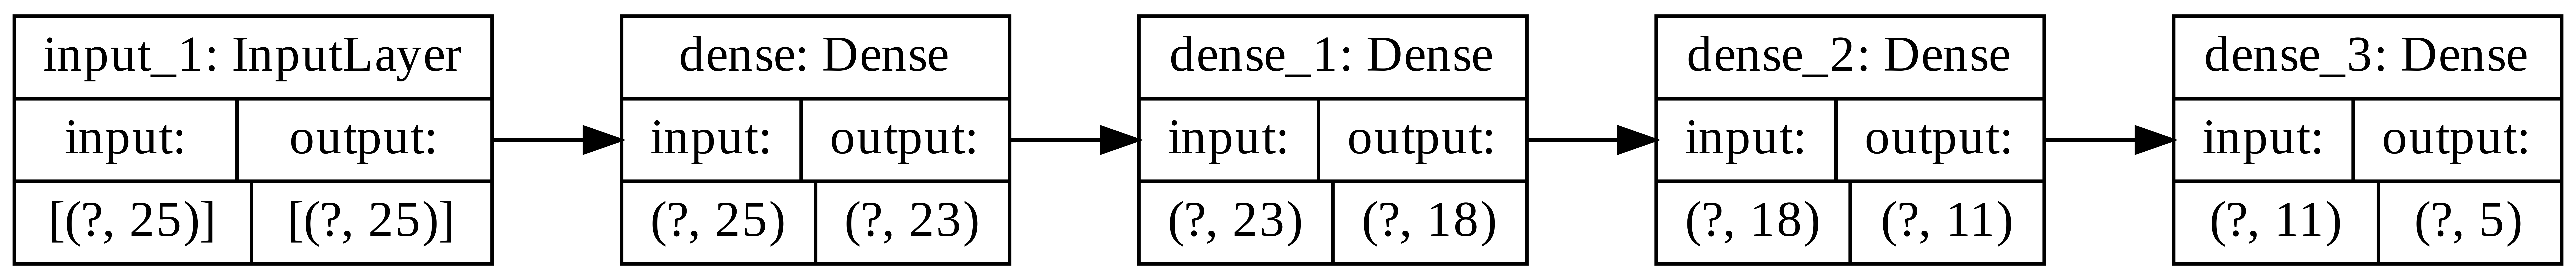

In [ ]:
!mkdir -p images
display(tf.keras.utils.plot_model(model, to_file='images/model.png', show_shapes=True, show_layer_names=True, expand_nested=True, dpi=1200, rankdir='LR'))

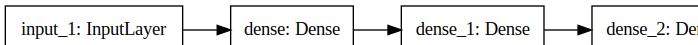

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

svg_plot = tf.keras.utils.model_to_dot(model, show_shapes=False, show_layer_names=True, rankdir='LR')
SVG(svg_plot.create(prog='dot', format='svg'))

In [ ]:
# with open('images/model.svg', 'w') as f:
#     f.write(svg_plot.decode('utf-8'))
svg_plot.write_svg('images/model.svg')

True

In [ ]:
%tensorboard --logdir $tensorboard_logs --host localhost --port 6006